<div>
  <img style="float: left;"  width="140" src=" 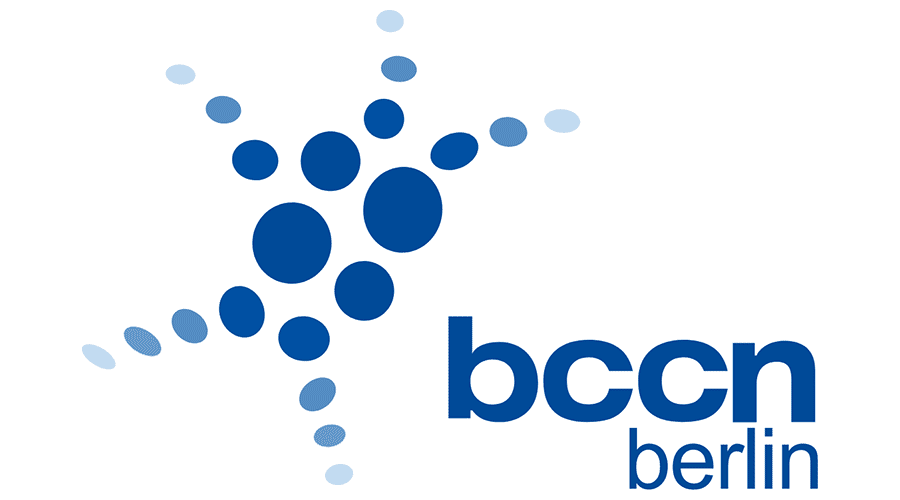">
</div>

<h1 id="course-title-heading">
    <div style="text-align: right">
        Computational Modeling Practical Course
        <br>
    </div>
</h1>

<div style="text-align: left; float: left">
    Bernstein Center for Computational Neuroscience Berlin
    <br>Lecturer: Prof. Dr. Henning Sprekeler
    <br>Tutors: Simone Ciceri
</div>

<br>
<h2>
<br>
<br>Final Project
</h2>

<div style="text-align: left">
    Gerardo Parra
</div>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm

## Introduction
Reports of mental disorders that interfere with focus and task execution, such as major deppressive disorder and attention deficit hyperactivity disorder, have been increasing for several years **(cite)**. Moreover, sociological trends such as growing proportions of young people who identify as introverted and spread of concepts like "bed rotting" point towards a population increasingly struggling with motivation and energy. While the underlying causes are undoubtedly numerous and difficult to disentangle, a mathematical model of the phenomenologically experience of motivation and energy could provide a framework for assessing important factors. I created a **n-dimensional** system to study the dynamics of motivation and energy in response to personal decisions and environmental influences, such as food, sleep and circadian rhythms, mental and physical activity

The physiological and psychological processes underlying these two variables are complex and high dimensional: it is not possible to capture all relevant parts in a simple, interpretable model and particualrly within the scope of this project. Moreover, the goal of this project is primarily the application of the mathematical repertoire we developed in class, not scientific accuracy. I therefore emphasize that while I conducted some superficial reserach to inform the development of this model, the model is partly formed by intuition and is not rigorously scientifically based.

## Methods
First I define some basic terminology and distinguish certain similar concepts.

I then state my assumptions and conventions.

I begin by modeling the human circadian rhythm. The circadian rhythm is an automatic internal clock regulating alertness which is highly sensitive to light input. The circadian rhythm has an intrinsic period slightly greater than 24 hours long (24.18 hours), but resets its phase in response to light input. Given the relation of this internal clock to the sensation of alertness and drowsiness, we begin by modeling this system.
\begin{align}
C(t) &= \frac{1 - \text{cos}\left(\frac{2\pi}{T}t\right)}{2} \\
\frac{dT}{dt} &= -\text{tanh}\left(T-\mu_T\right)\text{exp}\left(-\frac{\left(T-\mu_T\right)^2}{2\sigma_T^2}\right)  - \alpha_Lf_L\left(L,\phi\right) \\
f_L(L,\phi) &= \text{PRC}\left(\phi\right)L \\
\text{PRC}\left(\phi\right) &= \text{exp}\left(-\frac{\left(\phi-\frac{\pi}{2}\right)^2}{\pi^2/8}\right)-\text{exp}\left(-\frac{\left(\phi-2\pi\right)^2}{\pi^2/8}\right)
\end{align}

where $C$ is a variable representing one's circadian rhythm, $T$ is the variable whose dynamics we model representing the period of the circadian rhythm, and $\phi$ is the phase of the sinusoidal function, namely $\phi\left(t,T\right) = 2\pi \lfloor{\frac{t}{T}}\rfloor$. PRC represents the phase response curve, which defines the impact of an input (light in this case) on the phase of the circadian rhythm depending on the phase of the rhythm at the time it is received. This function was designed to resemble PRCs as documented in the circadian rhythm literature (**CITE**) and was constructed by summing two exponentials, a positive one centered at $\frac{\pi}{2}$ to create the phase advancing effect of light received during one's morning, and a negative one centered at $2\pi$ to represent the phase delay caused by light during one's night. The parameters and intial conditions were manually chosen to create realistic dynamics, namely $\mu_T=24.5, \sigma_T=0.11, \alpha_L=2$, and $T_0=24.5$.



In [ ]:
## Universal variables
METHOD  = 'RK45' #'RK23' #'DOP853' #'LSODA' #'Radau' #
T0      = 24.5
ALPHA_L = 2
SIGMA_T = 0.11

In [148]:
def set_day_xticks(t_span, ax=None):
    if ax is not None:
        ax.set_xticks(np.arange(t_span[0],t_span[1],24), np.arange(t_span[0]/24,t_span[1]/24,1).astype(int))
    else:
        plt.xticks(np.arange(t_span[0],t_span[1],24), np.arange(t_span[0]/24,t_span[1]/24,1).astype(int))

def plot_days(days, ax=None, amp=(-1.1,1)):
    if ax is not None:
        ax.vlines(days, amp[0], amp[1], colors='#ccc', linestyles='dashed')
    else:
        plt.vlines(days, amp[0], amp[1], colors='#ccc', linestyles='dashed')

## 1. Circadian rhythm

### a. Phase response curve

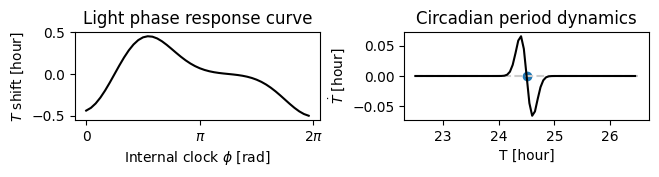

In [149]:
# Obtain the phase of a periodic function
def phi(t, T, t0=0):
    x = (t - t0)/T
    x_frac = x - np.floor(x)
    return 2*np.pi * x_frac

# Define circadian PRC by summing Gaussian PDFs
def PRC(phase):
    return norm.pdf(phase,loc=np.pi/2,scale=np.pi/4)-norm.pdf(phase,loc=2*np.pi,scale=np.pi/4)-norm.pdf(phase,loc=0,scale=np.pi/4)

def L_input(t, params):
    """
    Determines light input based on time of day with configurable hours and intensity.
    
    Parameters:
    - t: scalar or numpy array of time values (hours).
    - params: Dictionary with:
        - 'hours': List of tuples [(start, end)] defining light-on periods.
        - 'amp': Single amplitude value or list of amplitudes (one per time range).
    
    Returns:
    - A numpy array (or scalar) indicating light presence, scaled by amplitude.
    """
    t_mod = np.mod(t, 24)  # Convert to 24-hour cycle
    light = np.zeros_like(t_mod, dtype=float)

    # Ensure amp is a list, or convert it to a list of the same value
    amps = params['amp']
    if not isinstance(amps, (list, np.ndarray)):  
        amps = [amps] * len(params['hours'])  # Repeat single amp for all peaks
    
    for (start, end), amp in zip(params['hours'], amps):
        light += amp * ((t_mod >= start) & (t_mod < end))

    return light

# Define Light nonlinearity as a function of internal clock phase
def f_L(phi, L):
    return PRC(phi) * L

# Define dynamics of T: circadian rhythm period
def dT(T, mu=T0, sigma=SIGMA_T): 
    # Original: dtheta_dt = freq + f_L(theta % (2*np.pi), L_input(t,light_params)) - .001 * theta
    # Old: -(T - mu) * (T - (mu-1))**2 * (T - (mu+1))**2
    # Old: np.exp(-(T-mu)**2) * (T - mu)*(T - (mu-1))*(T - (mu+1))
    # Simple: -(T-mu)/TAU_T
    # Sigmoidal simple: -np.tanh(T-mu)/TAU_T
    return -np.tanh(T-mu) * np.exp(-(T-mu)**2/(2*sigma**2))

# Define system dynamics
def circadian(t, y, light_params, alpha_L=ALPHA_L):
    T    = y[0]
    L    = L_input(t, light_params)
    dTdt =  dT(T) - alpha_L * f_L(phi(t,T=T), L)
    return [dTdt]

# Make plots of circadian rhythm solutions
def plot_circadian(solution, ax=None, figsize=(6,3)):
    # Old: rhythm = (1 -np.cos(solution.y[0])) / 2 
    rhythm = (1 - np.cos(2*np.pi/solution.y[0] * solution.t)) / 2

    new_fig = ax is None  # Check if we need to create a new figure
    if new_fig:
        fig, ax = plt.subplots(figsize=figsize)  # Create new figure if no axis is given
    else:
        fig = ax.get_figure()  # Get the parent figure of the existing axis

    ax.plot(solution.t, rhythm, 'k')
    ax.set_ylabel("C(t)")

    if new_fig:
        plt.show()  # Show only if a new figure was created

    return fig, ax  # Return figure and axis for customization

## Plot system components
fig, ax = plt.subplots(1, 2, figsize=(7,2))
fig.tight_layout(pad=3)
# Plot phase response curve
day = np.arange(0, 24, 0.5)
ax[0].plot(phi(day,24), PRC(phi(day,24)), 'k')
ax[0].set_xlabel(r'Internal clock $\phi$ [rad]'), ax[0].set_ylabel(r'$T$ shift [hour]')
ax[0].set_xticks([0,np.pi,2*np.pi],['0',r'$\pi$',r'$2\pi$'])
ax[0].set_title('Light phase response curve')

# Plot dT(T)
T = np.arange(T0-2,T0+2,0.05)
ax[1].hlines(0, T0-2, T0+2, '#ccc', '--')
ax[1].plot(T, dT(T), 'k'), ax[1].scatter(T0,0)
ax[1].set_xlabel('T [hour]'), ax[1].set_ylabel(r'$\dot{T}$ [hour]')
ax[1].set_title('Circadian period dynamics')
plt.show()

### b. Circadian rhythm with phase leakily integrating light input

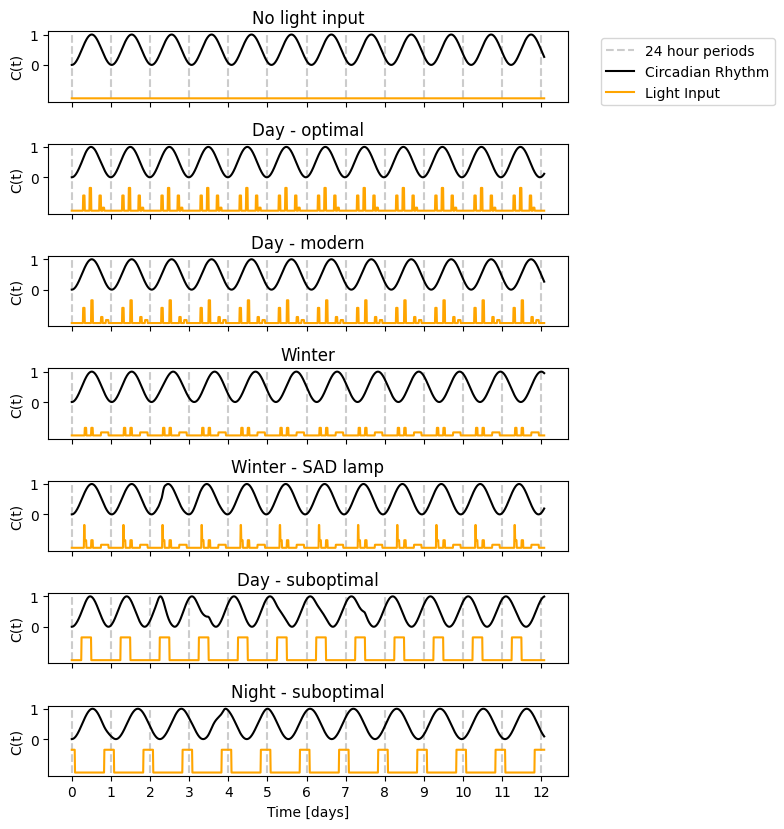

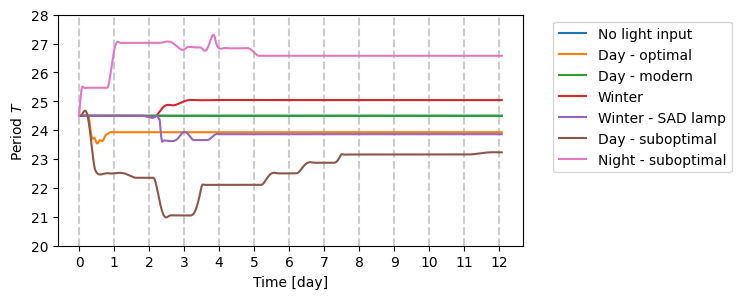

In [164]:
# Simulation parameters 
y0 = [T0]
t_span = (0, 290)
t_eval = np.arange(t_span[0], t_span[1], 0.2)
days   = np.arange(t_span[0], t_span[1]+1, 24)
# Light conditions
conditions = {
    'No light input':     {'hours': [], 'amp': 1},
    'Day - optimal':      {'hours': [(7,8),(11,12),(17,18),(19,20)], 'amp': [0.5, 0.75, 0.5, 0.1]},
    'Day - modern':       {'hours': [(7,8),(12,13),(18,19),(21,22.5)], 'amp': [0.5, 0.75, 0.2, 0.1]},
    'Winter':             {'hours': [(8,9),(12,13),(18,22.5)], 'amp': [0.25, 0.25, 0.1]},
    'Winter - SAD lamp':  {'hours': [(7.5,8),(8,9),(12,13),(18,22.5)], 'amp': [0.75,0.25, 0.25, 0.1]},
    'Day - suboptimal':   {'hours': [(6,12)], 'amp': 0.75},
    'Night - suboptimal': {'hours': [(20,24),(0,2)], 'amp': 0.75}
}
n_cond = len(conditions)

## Solve and plot solutions


fig, ax = plt.subplots(n_cond, 1, figsize=(8, 1.2*n_cond), sharex=True)  # Three subplots with shared x-axis
solutions = []
for i, cond in enumerate(conditions.keys()):
    solutions.append(solve_ivp(circadian, t_span, y0, t_eval=t_eval, args=(conditions[cond],), method=METHOD))
    plot_days(days, ax[i])
    plot_circadian(solutions[i], ax=ax[i])
    ax[i].plot(solutions[i].t, L_input(solutions[i].t, conditions[cond]) - 1.1, label="Light Input", color="orange")
    ax[i].set_title(cond)
    ax[i].set_yticks([0, 1])
ax[0].legend(['24 hour periods',"Circadian Rhythm", "Light Input"], loc="upper left", bbox_to_anchor=(1.05, 1))
plt.xlabel('Time [days]'), set_day_xticks(t_span)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Plot periods
plt.figure(figsize=(6,3))
plot_days(days, amp=(20,28))
for i, cond in enumerate(conditions.keys()):
    plt.plot(solutions[i].t, solutions[i].y[0], label=cond)
plt.xlabel('Time [day]'), set_day_xticks(t_span)
plt.ylabel(r'Period $T$'), plt.ylim(20,28)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()

## 2. Sleep
We next model sleep and its interactions with the circadian rhythm. Sleep 
\begin{align}
\dot{S} = \frac{S}{\tau_S}
\end{align}

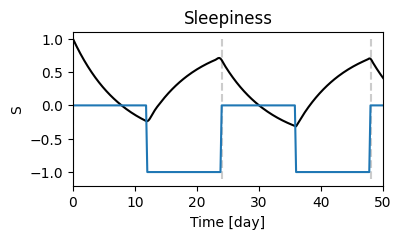

In [165]:
R = lambda t, params : L_input(t, params)

def sleep(t, y, params):
    S    = y[0]
    dSdt = (1-S)/params['tau_S'] - R(t, params['rest'])/params['tau_R']
    return [dSdt]

sleep_params = {
    'S0':    [1],
    'tau_S': 8,
    'tau_R': 5,
    'rest': {'hours': [(0,12)], 'amp': 1}
}

solutions = solve_ivp(sleep, t_span, sleep_params['S0'], t_eval=t_eval, args=(sleep_params,))

plt.figure(figsize=(4,2))
plot_days(days)
plt.plot(solutions.t, solutions.y[0], 'k')
plt.plot(solutions.t, L_input(solutions.t, sleep_params['rest'])-1)
plt.xlabel('Time [day]')#, set_day_xticks()
plt.ylabel('S'), plt.title('Sleepiness')
plt.xlim(0,50)
plt.show()